# **Homework 10 - Anomaly Detection**


## **goal**

----- strong baseline -----
0.64367      
----- simple baseline -----
0.54022   

**助教的 code:**       
KNN => 0.61855      
PCA => 0.58829     
AE  => fcn: 0.58737 / cnn: 0.55259/ vae: 0.58219

# Load and preprocess data

In [ ]:
folder_path = './'

In [ ]:
# TA
# !gdown --id '1_zT3JOpvXFGr7mkxs3XJDeGxTn_8pItq' --output train.npy 
# !gdown --id '11Y_6JDjlhIY-M5-jW1rLRshDMqeKi9Kr' --output test.npy 

# mine
!gdown --id '11N-BEVu5jIyRaDcF_NpuWWHRVDuKdQvB' --output train.npy 
!gdown --id '1dJQa-yVuSXvVjjcfOfUOAXBuRZQjm230' --output test.npy

import numpy as np

# allow_pickle: 可選，布爾值，允許使用 Python pickles 保存對像數組，Python 中的 pickle 用於在保存到磁盤文件或從磁盤文件讀取之前，對對象進行序列化和反序列化。
train = np.load('train.npy', allow_pickle=True) 
test = np.load('test.npy', allow_pickle=True)

!ls
# train 40000 筆
# test 10000 筆

# Task

這份作業要執行的 task 是 semi-supervised anomaly detection，也就是說 training set 是乾淨的，testing 的時候才會混進 outlier data (anomaly)。
我們以某個簡單的 image dataset（image 加上他們的 label（分類））作為示範，training data 為原先 training set 中的某幾類，而 testing data 則是原先 testing set 的所有 data，要偵測的 anomaly 為 training data 中未出現的類別。label 的部分，1 為 outlier data，而 0 為 inlier data（相對於 outlier）。正確率以 AUC 計算。

方法以下列舉 3 種： KNN, PCA, Autoencoder。

In [ ]:
import random
import torch
import numpy as np

# 固定隨機種子
def same_seeds(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(0)

# Autoencoder

# Models & loss

課程影片參見：https://www.youtube.com/watch?v=6W8FqUGYyDo&list=PLJV_el3uVTsOK_ZK5L0Iv_EQoL1JefRL4&index=8

Fully Convolution Network Introduction: https://zhuanlan.zhihu.com/p/31428783

fcn_autoencoder and vae are from https://github.com/L1aoXingyu/pytorch-beginner

conv_autoencoder is from https://github.com/jellycsc/PyTorch-CIFAR-10-autoencoder/

同學們可以嘗試各種不同的 VAE 架構

Cross Entropy introduction:     
https://medium.com/@chungyizhen/cross-entropy%E7%9A%84%E7%9B%B4%E8%A7%80%E7%90%86%E8%A7%A3-82e525e3780c      
KLD introduction:     
https://www.itread01.com/content/1548996871.html

Con Transposed 範例：       
    
<img src="https://imgur.com/qjh8hrK.png" width="500px">

TA

In [ ]:
# TA
# 參考用的
import torch
from torch import nn
import torch.nn.functional as F


class fcn_autoencoder(nn.Module):
    def __init__(self):
        # 其中的super類的作用是繼承的時候，調用含super的各個的基類__init__函數，如果不使用super，就不會調用這些類的__init__函數，
        # 除非顯式聲明。而且使用super可以避免基類被重複調用。
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # Linear的創建需要兩個參數，inputSize (輸入節點數) 和 outputSize (輸出節點數)
            nn.Linear(32 * 32 * 3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), nn.Linear(128, 32 * 32 * 3
            ), nn.Tanh())

    def forward(self, x):
        # 在 forward 函數裡定義輸入和輸出值的關係
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16] ps.padding 後從 32 => 34，再從 34/2 - 1= 16
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]   ps.padding 後從 16 => 18，再從 18/2 - 1= 8 
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]   ps.padding 後從 8 => 10，再從 10/2 - 1= 4
            nn.ReLU(),
    # 			nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]   ps.padding 後從 4 => 6，再從 6/2 - 1= 2
    #       nn.ReLU(),
        )
        self.decoder = nn.Sequential(
#             nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4] (3+2+3)
#             nn.ReLU(),
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(32*32*3, 400)
        self.fc21 = nn.Linear(400, 20) #mean
        self.fc22 = nn.Linear(400, 20) #var
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 32*32*3)

    def encode(self, x):
        # 其中nn.ReLU作為一個層結構，必須添加到nn.Module容器中才能使用，而F.ReLU則作為一個函數調用，看上去作為一個函數調用更方便更簡潔。
        # 具體使用哪種方式，取決於編程風格。
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() # 我們先將所有的數字乘0.5, 再求指數，可以發現當使用exp_()的時候值被修改了，而使用exp()時沒有被修改。
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return F.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x) # 編碼
        z = self.reparametrize(mu, logvar) # 重新參數化成正態分布
        return self.decode(z), mu, logvar # 解碼，同時輸出均值方差


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # 最早 KL divergence 就是從信息論裡引入的，不過既然題主問的是 ML 中的應用，就不多做具體介紹。
    # 只是簡單概述給定真實概率分佈P和近似分佈Q，KL divergence所表達的就是如果我們用一套最優的壓縮機制(compression scheme)來儲存Q的分佈，
    # 對每個從P來的sample我需要多用的bits（相比我直接用一套最優的壓縮機制來儲存P的分佈）。
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return mse + KLD


Mine

In [ ]:
# mine
import torch
from torch import nn
import torch.nn.functional as F


class fcn_autoencoder(nn.Module): 
    def __init__(self):
        # 其中的super類的作用是繼承的時候，調用含super的各個的基類__init__函數，如果不使用super，就不會調用這些類的__init__函數，
        # 除非顯式聲明。而且使用super可以避免基類被重複調用。
        super(fcn_autoencoder, self).__init__()
        # self.encoder = nn.Sequential(
        # # Linear的創建需要兩個參數，inputSize (輸入節點數) 和 outputSize (輸出節點數)
        #     nn.Linear(32 * 32 * 3, 128),
        #     nn.ReLU(True),
        #     nn.Linear(128, 64),
        #     nn.ReLU(True), 
        #     nn.Linear(64, 12), 
        #     nn.ReLU(True), 
        #     nn.Linear(12, 3))
        # self.decoder = nn.Sequential(
        #     nn.Linear(3, 12),
        #     nn.ReLU(True),
        #     nn.Linear(12, 64),
        #     nn.ReLU(True),
        #     nn.Linear(64, 128),
        #     nn.ReLU(True), 
        #     nn.Linear(128, 32 * 32 * 3),
        #     nn.Tanh())
        self.encoder = nn.Sequential(
            # Linear的創建需要兩個參數，inputSize (輸入節點數) 和 outputSize (輸出節點數)
            nn.Linear(32 * 32 * 3, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 32 * 32 * 3),
            nn.Tanh())

    def forward(self, x):
        # 在 forward 函數裡定義輸入和輸出值的關係
        x = self.encoder(x)
        x = self.decoder(x) #只取 encode vector
        return x



class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16] ps.padding 後從 32 => 34，再從 34/2 - 1= 16
        #     nn.BatchNorm2d(12),
        #     nn.ReLU(),
        #     nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]   ps.padding 後從 16 => 18，再從 18/2 - 1= 8 
        #     nn.BatchNorm2d(24),
        #     nn.ReLU(),
			  #     nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]   ps.padding 後從 8 => 10，再從 10/2 - 1= 4
        #     nn.BatchNorm2d(48),
        #     nn.ReLU(),
        #     nn.Conv2d(48, 96, 4, stride=2, padding=1),           # [batch, 96, 2, 2]   ps.padding 後從 4 => 6，再從 6/2 - 1= 2
        #     nn.BatchNorm2d(96),
        #     nn.ReLU(),
        #     nn.Conv2d(96, 192, 4, stride=2, padding=1),           # [batch, 192, 2, 2]   ps.padding 後從 4 => 6，再從 6/2 - 1= 2
        #     nn.BatchNorm2d(192),
        #     nn.ReLU(),
        #     nn.Conv2d(192, 384, 4, stride=2, padding=1),           # [batch, 96, 2, 2]   ps.padding 後從 4 => 6，再從 6/2 - 1= 2
        #     nn.BatchNorm2d(384),
        #     nn.ReLU(),
        # )

        # 使用 pooling
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, 5, 1, 2),  # [64, 32, 32] ps.padding 後從 32 => 36，再從 36-5+1 = 32
            nn.BatchNorm2d(64),
            # 2D Normalization
            # class torch.nn.BatchNorm2d(num_features, eps=1e-05, momentum=0.1, affine=True)，
            nn.Tanh(),
            nn.MaxPool2d(2, 2, 0),        # [64, 16, 16] 32/2 = 16

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 16, 16] ps.padding 後從 16 => 18，再從 18-3+1 = 16
            nn.BatchNorm2d(128),
            nn.Tanh(),
            nn.MaxPool2d(2, 2, 0),        # [128, 8, 8] 16/2= 8
            
            nn.Conv2d(128, 256, 3, 1, 1), # [256, 8, 8] ps.padding 後從 8 => 10，再從 10-3+1 = 8
            nn.BatchNorm2d(256),
            nn.Tanh(),
            nn.MaxPool2d(2, 2, 0),       # [256, 4, 4] 8/2= 4

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 4, 4] ps.padding 後從 4 => 6，再從 6-3+1 = 4
            nn.BatchNorm2d(512),
            nn.Tanh(),
            nn.MaxPool2d(2, 2, 0)        # [512, 2, 2] 4/2= 2
        )
        # nn.ReLU(inplace = True)
        # inplace=True means that it will modify the input directly, without allocating any additional output. 
        # It can sometimes slightly decrease the memory usage, but may not always be a valid operation (because the original input is destroyed). 
        # However, if you don’t see an error, it means that your use case is valid.
        
        # self.decoder = nn.Sequential(
        #     nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4] (3+2+3)
        #     nn.ReLU(),
			  #     nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
        #     nn.ReLU(),
			  #     nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
        #     nn.Tanh(),
        # )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512, 128, 7, stride=1),    # [256, 8, 8]     (3+2+3)
            nn.Tanh(),
            # nn.ConvTranspose2d(256, 128, 5, stride=1),    # [128, 12, 12]   (2+8+2)
            # nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 9, stride=1),     # [64, 16, 16]    (4+8+4)
            nn.Tanh(),
            nn.ConvTranspose2d(64, 3, 17, stride=1),      # [3, 32, 32]       (8+16+8)
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x) #只取 encode vector
        return x


class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # self.fc1 = nn.Linear(32*32*3, 400)
        # self.fc21 = nn.Linear(400, 20) #mean
        # self.fc22 = nn.Linear(400, 20) #var
        # self.fc3 = nn.Linear(20, 400)
        # self.fc4 = nn.Linear(400, 32*32*3)
        self.fc1 = nn.Linear(32*32*3, 256)
        self.fc2 = nn.Linear(256, 400)
        self.fc31 = nn.Linear(400, 20) #mean 改不只 20(?)
        self.fc32 = nn.Linear(400, 20) #var
        self.fc4 = nn.Linear(20, 256)
        self.fc5 = nn.Linear(256, 400)
        self.fc6 = nn.Linear(400, 32*32*3)

    def encode(self, x):
        # 其中nn.ReLU作為一個層結構，必須添加到nn.Module容器中才能使用，而F.ReLU則作為一個函數調用，看上去作為一個函數調用更方便更簡潔。
        # 具體使用哪種方式，取決於編程風格。
        # h1 = F.relu(self.fc1(x))
        # return self.fc21(h1), self.fc22(h1)
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        return self.fc31(h2), self.fc32(h2)


    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() # 我們先將所有的數字乘0.5, 再求指數，可以發現當使用exp_()的時候值被修改了，而使用exp()時沒有被修改。
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        # h3 = F.relu(self.fc3(z))
        # return F.sigmoid(self.fc4(h3))
        h4 = F.relu(self.fc4(z))
        h5 = F.relu(self.fc5(h4))
        return F.sigmoid(self.fc6(h5))

    def forward(self, x):
        mu, logvar = self.encode(x) # 編碼
        z = self.reparametrize(mu, logvar) # 重新參數化成正態分布
        return self.decode(z), mu, logvar # 解碼，同時輸出均值方差
        # return self.encode(x) # #只取 encode vector
        


def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)  # mse loss
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # 最早KL divergence就是從信息論裡引入的，不過既然題主問的是ML中的應用，就不多做具體介紹。
    # 只是簡單概述給定真實概率分佈P和近似分佈Q，KL divergence所表達的就是如果我們用一套最優的壓縮機制(compression scheme)來儲存Q的分佈，
    # 對每個從P來的sample我需要多用的bits（相比我直接用一套最優的壓縮機制來儲存P的分佈）。
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return mse + KLD


In [ ]:
# CNN_VAE

class CNN_VAE(nn.Module):
    def __init__(self):
        super(CNN_VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            # [batch, 12, 16, 16] ps.padding 後從 32 => 34，再從 34/2 - 1= 16
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),           # [batch, 24, 8, 8]   ps.padding 後從 16 => 18，再從 18/2 - 1= 8 
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),           # [batch, 48, 4, 4]   ps.padding 後從 8 => 10，再從 10/2 - 1= 4
            nn.ReLU(),
        )

        self.fc_1 = nn.Sequential(
            # flatten
            nn.Linear(48*4*4, 256),
            torch.nn.Dropout(0.7),
            nn.ReLU(),
            nn.Linear(256, 64),
            torch.nn.Dropout(0.7),
            nn.ReLU()
        )

        self.fc_21 = nn.Linear(64, 32) #mean 改不只 20(?)
        self.fc_22 = nn.Linear(64, 32) #var

        # self.fc_3 = nn.Sequential(
        #     # re_flatten
        #     nn.Linear(32, 64),
        #     nn.ReLU(),
        #     nn.Linear(64, 256),
        #     nn.ReLU(),
        #     nn.Linear(256, 48*4*4),
        # )
        
        # self.decoder = nn.Sequential(
			  #     nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
        #     nn.ReLU(),
			  #     nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),   # [batch, 3, 32, 32]
        #     nn.Tanh(),
        # )

        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 32*32*3)
        )

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_() 
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)

    def forward(self, x):
        encode = self.encoder(x)
        encode = encode.view(encode.size()[0], -1)
        fc1 = self.fc_1(encode)

        mu = self.fc_21(fc1) 
        logvar = self.fc_22(fc1) 

        z = self.reparametrize(mu, logvar) 
        # fc3 = self.fc_3(z)
        decode = self.decoder(z)
        return F.sigmoid(decode), mu, logvar     

def loss_vae(recon_x, x, mu, logvar, criterion):
    """
    recon_x: generating images
    x: origin images
    mu: latent mean
    logvar: latent log variance
    """
    mse = criterion(recon_x, x)  # mse loss
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KLD = torch.sum(KLD_element).mul_(-0.5)
    # KL divergence
    return mse + KLD


查看參數量

In [ ]:
model = fcn_autoencoder().cuda()

from torchsummary import summary
summary(model, input_size=(1, 3*32*32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 512]       1,573,376
              ReLU-2               [-1, 1, 512]               0
            Linear-3               [-1, 1, 256]         131,328
              ReLU-4               [-1, 1, 256]               0
            Linear-5               [-1, 1, 128]          32,896
              ReLU-6               [-1, 1, 128]               0
            Linear-7                [-1, 1, 64]           8,256
              ReLU-8                [-1, 1, 64]               0
            Linear-9                [-1, 1, 12]             780
             ReLU-10                [-1, 1, 12]               0
           Linear-11                 [-1, 1, 3]              39
           Linear-12                [-1, 1, 12]              48
             ReLU-13                [-1, 1, 12]               0
           Linear-14                [-1

# Training

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
# training 時做 data augmentation
# Data augmentation原理
# 一張圖片經過旋轉、調整大小、比例尺寸，或者改變亮度色溫、翻轉等處理後，我們人眼仍能辨識出來是相同的相片，但是對機器來說那可是完全不同的新圖像了，
# 因此， Data augmentation就是將dataset中既有的圖片予以修改變形，以創造出更多的圖片來讓機器學習，彌補資料量不足的困擾。
train_transform = transforms.Compose([
    transforms.ToPILImage(), #轉成 python 圖片
    transforms.RandomHorizontalFlip(), # 隨機將圖片水平翻轉
    transforms.RandomRotation(15), # 隨機旋轉圖片，表示在（-15，+15）之间随机旋转
    transforms.ToTensor(), # 將圖片轉成 Tensor，並把數值 normalize 到 [0,1] (data normalization) ps. Tensor 為多維張量
    # transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.5, 0.5, 0.5)) # 歸一化到 [-1, 1]
])
# testing 時不需做 data augmentation
test_transform = transforms.Compose([
    transforms.ToPILImage(),                                    
    transforms.ToTensor(),
])
class ImgDataset(Dataset):
    def __init__(self, x, y=None, transform=None):
    # def __init__(self, x, y=None, transform=True):
        self.x = x
        # label is required to be a LongTensor
        self.y = y
        if y is not None:
            self.y = torch.LongTensor(y)
        self.transform = transform
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index):
        X = self.x[index]
        if self.transform is not None:
            X = self.transform(X)
        if self.y is not None:
            Y = self.y[index]
            return X, Y
        else:
            return X

In [ ]:
batch_size = 64
train_set = ImgDataset(train, None, train_transform)
test_set = ImgDataset(test, None, test_transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [ ]:
import time

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)

task = 'ae'
if task == 'ae':
    training_total_time = time.time()

    num_epochs = 3
    batch_size = 64
    learning_rate = 1e-3

    #{'fcn', 'cnn', 'vae', 'cnn_vae'} 
    model_type = 'cnn' 

    x = train
    if model_type == 'fcn' or model_type == 'vae':
        x = x.reshape(len(x), -1)
        
    data = torch.tensor(x, dtype=torch.float)
    # data1 = torch.tensor(x, dtype=torch.float)

    train_dataset = TensorDataset(data)
    # train_dataset = ImgDataset(data1, None, train_transform)
    
    # RandomSampler 參數作用：
    # data_source: 同上
    # num_samples: 指定採樣的數量，默認是所有。
    # replacement: 若為True，則表示可以重複採樣，即同一個樣本可以重複採樣，這樣可能導致有的樣本採樣不到。
    #              所以此時我們可以設置num_samples來增加採樣數量使得每個樣本都可能被採樣到。

    # train_sampler = RandomSampler(train_dataset)
    # train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


    model_classes = {'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), 'cnn_vae': CNN_VAE()} # 使用不同的 model
    model = model_classes[model_type].cuda()
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(
        model.parameters(), lr=learning_rate)
    
    best_loss = np.inf #numpy用IEEE-754格式，一般numpy.inf是float64格式，能表示最大的數是±(1−2^(−53))∗(2^1024) = ±1.79769×(10^308)
    model.train()
    print('epoch cost time limit =', 30*60/num_epochs)

    for epoch in range(num_epochs):
        training_start_time = time.time()
        for data in train_dataloader:
        # for i, data in enumerate(train_dataloader):
            if model_type == 'cnn' or model_type == 'cnn_vae':
                img = data[0].transpose(3, 1).cuda()
                # img = data.cuda() #data augmentaion
            else:
                img = data[0].cuda()
                # img = data.cuda() #data augmentaion
            # ===================forward=====================
            output = model(img)
            if model_type == 'vae':
                loss = loss_vae(output[0], img, output[1], output[2], criterion)
            elif model_type == 'cnn_vae':
                loss = loss_vae(output[0], data[0].reshape(-1, 3072).cuda(), output[1], output[2], criterion)
            else:
                loss = criterion(output, img)
            # ===================backward====================
            optimizer.zero_grad() # 將梯度初始化為零（因為一個batch的loss關於weight的導數是所有sample的loss關於weight的導數的累加和）
            loss.backward() # 反向傳播求梯度
            optimizer.step() # 更新所有參數
            # ===================save====================
            if loss.item() < best_loss:
                best_loss = loss.item()
                torch.save(model, 'best_model_{}.pt'.format(model_type))
                print('save model')

        if epoch%10 == 0:
            torch.save(model, '{}_'.format(epoch) + 'model_{}.pt'.format(model_type))
            print('save model', ', loss =', loss.item())
        # ===================log========================
        print('epoch [{}/{}], loss:{:.4f}'
              .format(epoch + 1, num_epochs, loss.item()), ', training cost time =', time.time() - training_start_time, '(sec)', 'best loss =', best_loss)
        
    print('total training time =', time.time() - training_total_time, '(sec)', 'best loss =', best_loss)
        




# Evaluation

將 testing 的圖片輸入 model 後，可以得到其重建的圖片，並對兩者取平方差。可以發現 inlier 的平方差應該與 outlier 的平方差形成差距明顯的兩群數據。

In [ ]:
import time

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)

task = 'ae'
model_type = 'cnn'
batch_size = 64
MSE_loss = []

if task == 'ae':
    if model_type == 'fcn' or model_type == 'vae':
        y = test.reshape(len(test), -1)
    else:
        y = test
        
    data = torch.tensor(y, dtype=torch.float)
    test_dataset = TensorDataset(data)
    # SequentialSampler 這個看名字就很好理解，其實就是按順序對數據集採樣。
    # 其原理是首先在初始化的時候拿到數據集data_source，之後在__iter__方法中首先得到一個和data_source一樣長度的range可迭代器。每次只會返回一個索引值。 
    test_sampler = SequentialSampler(test_dataset) 
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size, shuffle = False)

    model_classes = {'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), 'cnn_vae': CNN_VAE()} # 使用不同的 model
    model = model_classes[model_type].cuda()
    # model = torch.load('best_model_{}.pt'.format(model_type), map_location='cuda')
    # model = torch.load(folder_path + 'best_model_{}_1.pt'.format(model_type), map_location='cuda') 
    model = torch.load(folder_path + 'baseline.pth', map_location='cuda') 

    encoded_test_images = []
    model.eval()
    reconstructed = list()
    criterion = nn.MSELoss()
    testing_start_time = time.time()
    for i, data in enumerate(test_dataloader): 
        if model_type == 'cnn' or model_type == 'cnn_vae':
            img = data[0].transpose(3, 1).cuda()
        else:
            img = data[0].cuda()

        # if model_type == 'vae':
        #     outputx = model.encode(img) #查看 encode vector dim (vae)
        # elif model_type == 'cnn_vae':
        #     outputx = model.encode(img) #查看 encode vector dim (vae)
        # else:
        #     outputx = model.encoder(img) #查看 encode vector dim (fcn, cnn)
          
        output = model(img)
        loss = criterion(output, img)

        if model_type == 'cnn':
            output = output.transpose(3, 1)
        elif model_type == 'vae' or model_type == 'cnn_vae':
            output = output[0]
        reconstructed.append(output.cpu().detach().numpy())
        MSE_loss.append([loss.cpu().detach().numpy(), data[0].cpu().detach().numpy(), output.cpu().detach().numpy()])

    # np.concatenate 傳入的參數必須是一個多個數組的元組或者列表
    # 另外需要指定拼接的方向，默認是 axis = 0，也就是說對0軸的數組對象進行縱向的拼接（縱向的拼接沿著axis= 1方向）；
    # 注：一般axis = 0，就是對該軸向的數組進行操作，操作方向是另外一個軸，即axis=1。
    reconstructed = np.concatenate(reconstructed, axis=0)

    if model_type == 'cnn_vae':
        anomality = np.sqrt(np.sum(np.square(reconstructed - y.reshape(-1, 3072)).reshape(len(y), -1), axis=1))
    else:
        anomality = np.sqrt(np.sum(np.square(reconstructed - y).reshape(len(y), -1), axis=1))
        
    y_pred = anomality
    print('testing cost time =', time.time() - testing_start_time, '(sec)')
    with open('best_model_{}_1_'.format(model_type) + 'prediction_1_repro.csv', 'w') as f:
        f.write('id,anomaly\n')
        for i in range(len(y_pred)):
            f.write('{},{}\n'.format(i+1, y_pred[i]))
    # score = roc_auc_score(y_label, y_pred, average='micro')
    # score = f1_score(y_label, y_pred, average='micro')
    # print('auc score: {}'.format(score))

# sort my MSE_loss
# sorted(MSE_loss, key = lambda s: s[0])
MSE_loss.sort(key = lambda s: s[0])

testing cost time = 0.7353761196136475 (sec)


In [ ]:
# save to drive
torch.save(model, folder_path + 'best.pth')

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type fcn_autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [ ]:
import matplotlib.pyplot as plt

# cnn
def no_axis_show(img, title='', cmap=None):
  # imshow, 縮放模式為nearest。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap, )
  # 不要顯示axis。
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title, fontsize = 15)

plt.figure(num='MSE_comparsion',figsize=(20, 20)) 
plt.subplot(4, 4, 1)
no_axis_show(MSE_loss[0][1].squeeze(), 'MSE_1st_smallest_original', )
plt.subplot(4, 4, 2)
no_axis_show(MSE_loss[0][2].squeeze(), 'MSE_1st_smallest_reconstructed', )
plt.subplot(4, 4, 3)
no_axis_show(MSE_loss[1][1].squeeze(), 'MSE_2nd_smallest_original', )
plt.subplot(4, 4, 4)
no_axis_show(MSE_loss[1][2].squeeze(), 'MSE_2nd_smallest_reconstructed', )
plt.subplot(4, 4, 5)
no_axis_show(MSE_loss[9998][1].squeeze(), 'MSE_2nd_largest_original', )
plt.subplot(4, 4, 6)
no_axis_show(MSE_loss[9998][2].squeeze(), 'MSE_2nd_largest_reconstructed', )
plt.subplot(4, 4, 7)
no_axis_show(MSE_loss[9999][1].squeeze(), 'MSE_1st_largest_original', )
plt.subplot(4, 4, 8)
no_axis_show(MSE_loss[9999][2].squeeze(), 'MSE_1st_largest_reconstructed', )
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


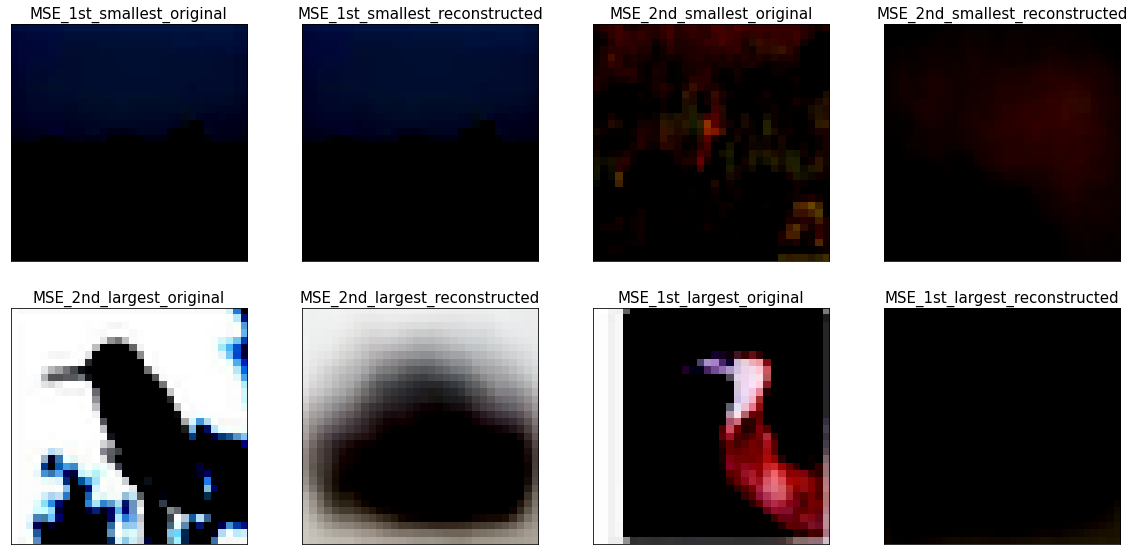

In [ ]:
import matplotlib.pyplot as plt

# fcn
def no_axis_show(img, title='', cmap=None):
  # imshow, 縮放模式為nearest。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap, )
  # 不要顯示axis。
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title, fontsize = 15)

plt.figure(num='MSE_comparsion',figsize=(20, 20)) 
plt.subplot(4, 4, 1)
no_axis_show(MSE_loss[0][1].reshape(32, 32, 3), 'MSE_1st_smallest_original', )
plt.subplot(4, 4, 2)
no_axis_show(MSE_loss[0][1].reshape(32, 32, 3), 'MSE_1st_smallest_reconstructed', )
plt.subplot(4, 4, 3)
no_axis_show(MSE_loss[1][1].reshape(32, 32, 3), 'MSE_2nd_smallest_original', )
plt.subplot(4, 4, 4)
no_axis_show(MSE_loss[1][2].reshape(32, 32, 3), 'MSE_2nd_smallest_reconstructed', )
plt.subplot(4, 4, 5)
no_axis_show(MSE_loss[9998][1].reshape(32, 32, 3), 'MSE_2nd_largest_original', )
plt.subplot(4, 4, 6)
no_axis_show(MSE_loss[9998][2].reshape(32, 32, 3), 'MSE_2nd_largest_reconstructed', )
plt.subplot(4, 4, 7)
no_axis_show(MSE_loss[9999][1].reshape(32, 32, 3), 'MSE_1st_largest_original', )
plt.subplot(4, 4, 8)
no_axis_show(MSE_loss[9999][2].reshape(32, 32, 3), 'MSE_1st_largest_reconstructed', )
plt.show()

# get encode vector

In [ ]:
import time

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.optim import Adam, AdamW
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)

batch_size = 64
task = 'ae'
model_type = 'fcn'
encoded_train_images = []
encoded_test_images = []

# with torch.no_grad()則主要是用於停止autograd模塊的工作，以起到加速和節省顯存的作用，
# 具體行為就是停止gradient計算，從而節省了GPU算力和顯存，但是並不會影響dropout和batchnorm層的行為。
with torch.no_grad():

########################### encoded_train_images ###############################

    model_classes = {'fcn':fcn_autoencoder(), 'cnn':conv_autoencoder(), 'vae':VAE(), 'cnn_vae': CNN_VAE()} #使用不同的 model
    model = model_classes[model_type].eval().cuda()
    model = torch.load('best_model_{}.pt'.format(model_type), map_location='cuda')

    model.eval()
    x = train
    if task == 'ae':
        if model_type == 'fcn' or model_type == 'vae':
            x = x.reshape(len(x), -1)
            
    data_train = torch.tensor(x, dtype=torch.float)
    train_dataset = TensorDataset(data_train)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    for data in train_dataloader:
        if model_type == 'cnn' or model_type == 'cnn_vae':
            img = data[0].transpose(3, 1).cuda()

        else:
            img = data[0].cuda()
        
        if model_type == 'vae':
          outputx = model.encode(img) #查看 encode vector dim (vae)
        else:
          outputx = model.encoder(img) #查看 encode vector dim (fcn, cnn)

        encoded_train_images.append(outputx) 

    print('finish encode_train_images')

############################ encoded_test_images ###############################

    model.eval()
    if task == 'ae':
        if model_type == 'fcn' or model_type == 'vae':
            y = test.reshape(len(test), -1)
        else:
            y = test
            
    data_test = torch.tensor(y, dtype=torch.float)
    test_dataset = TensorDataset(data_test)
    test_sampler = SequentialSampler(test_dataset) 
    test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size)
    for i, data in enumerate(test_dataloader): 
        if model_type == 'cnn' or model_type == 'cnn_vae':
            img = data[0].transpose(3, 1).cuda()

        else:
            img = data[0].cuda()
     
        if model_type == 'vae':
          outputx = model.encode(img) #查看 encode vector dim (vae)
        else:
          outputx = model.encoder(img) #查看 encode vector dim (fcn, cnn)

        encoded_test_images.append(outputx)
    print('finish encode_test_images')

finish encode_train_images
finish encode_test_images


# KNN

K-Nearest-Neighbor(KNN): 假設 training data 的 label 種類不多（e.g., < 20），然而因其為未知，可以猜測其為 n，亦即假設 training data 有 n 群。先用 K-means 計算 training data 中的 n 個 centroid，再用這 n 個 centroid 對 training data 分群。應該可以觀察到，inlier data 與所分到群的 centroid 的距離應較 outlier 的此距離來得小。

In [ ]:
# use AE encode vector
if model_type == 'vae':
    temp_1 = encoded_train_images[0][0].cpu().detach().numpy()
    for i in range(1, len(encoded_train_images)):
        temp = encoded_train_images[i][0].cpu().detach().numpy()
        temp_1 = np.append(temp, temp_1, axis=0)

    temp_2 = encoded_test_images[0][0].cpu().detach().numpy()
    for i in range(1, len(encoded_test_images)):
        temp = encoded_test_images[i][0].cpu().detach().numpy()
        temp_2 = np.append(temp, temp_2, axis=0)
else:
    temp_1 = encoded_train_images[0].cpu().detach().numpy()
    for i in range(1, len(encoded_train_images)):
        temp = encoded_train_images[i].cpu().detach().numpy()
        temp_1 = np.append(temp, temp_1, axis=0)

    temp_2 = encoded_test_images[0].cpu().detach().numpy()
    for i in range(1, len(encoded_test_images)):
        temp = encoded_test_images[i].cpu().detach().numpy()
        temp_2 = np.append(temp, temp_2, axis=0)

In [ ]:
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import f1_score, pairwise_distances, roc_auc_score
from scipy.cluster.vq import vq, kmeans

task = 'knn'

if task == 'knn':
    # 特殊用法：mat (or array).reshape(c, -1);  必須是矩陣格式或者數組格式，才能使用 .reshape(c, -1) 函數，
    # 表示將此矩陣或者數組重組，以 c行d列的形式表示（-1的作用就在此，自動計算d：d=數組或者矩陣裡面所有的元素個數/c,
    # d必須是整數，不然報錯）（reshape(-1, e)即列數固定，行數需要計算）
  
    # x = train.reshape(len(train), -1)
    # y = test.reshape(len(test), -1)
    # y = reconstructed.reshape(len(reconstructed), -1)
    x = temp_1.reshape(len(temp_1), -1)
    y = temp_2.reshape(len(temp_2), -1)
    # xy = np.append(x, y, axis=0)

    # list() 方法用於將元組轉換為列表。注：元組與列表是非常類似的，區別在於元組的元素值不能修改，元組是放在括號中，列表是放於方括號中。
    scores = list()
    # n = 9
    for n in range(1, 10):
    # if (n == 9):
      # Fit(): Method calculates the parameters μ and σ and saves them as internal objects.
      # 解釋：簡單來說，就是求得訓練集X的均值啊，方差啊，最大值啊，最小值啊這些訓練集X固有的屬性。可以理解為一個訓練過程
      # kmeans_x = MiniBatchKMeans(n_clusters=n, batch_size=100, random_state = 0).fit(x)
      kmeans_x = KMeans(n_clusters=n, random_state = 0).fit(x)

      y_cluster = kmeans_x.predict(y) # 預測
      # axis= 0 對a的橫軸進行操作，在運算的過程中其運算的方向表現為縱向運算
      # axis= 1 對a的縱軸進行操作，在運算的過程中其運算的方向表現為橫向運算
      y_dist = np.sum(np.square(kmeans_x.cluster_centers_[y_cluster] - y), axis=1)

      y_pred = y_dist
    #   score = f1_score(y_label, y_pred, average='micro')
    #   score = roc_auc_score(y_label, y_pred, average='micro')
    #   scores.append(score)
    # print(np.max(scores), np.argmax(scores))
    # print(scores)
    # print('auc score: {}'.format(np.max(scores)))


畫出降維圖

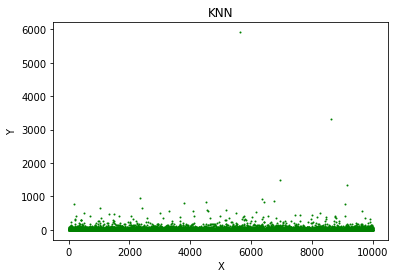

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_pred, 'ro',color = 'g', markersize = 1)
plt.title('KNN')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

取出經過 KNN 後的 encode_vector

In [ ]:
# for cnn
if (model_type == 'cnn'):
    encode_vector = kmeans_x.cluster_centers_[y_cluster].reshape(-1, 16, 512, 2, 2) #轉成 cnn_encode
    encode_vector = torch.from_numpy(encode_vector).cuda()  #numpy => tensor，記得放在 gpu

# for fcn  
elif (model_type == 'fcn'):
    encode_vector = kmeans_x.cluster_centers_[y_cluster].reshape(-1, 16, 3) #轉成 fcn_encode
    encode_vector = torch.from_numpy(encode_vector).cuda()  #numpy => tensor，記得放在 gpu

# for vae 
else:
    encode_vector = kmeans_x.cluster_centers_[y_cluster].reshape(-1, 16, 3) #轉成 vae_encode
    encode_vector = torch.from_numpy(encode_vector).cuda()  #numpy => tensor，記得放在 gpu

In [ ]:
print(len(y_pred))
print(y_pred)

with open('best_model_fcn_0_kmeans_prediction_1.csv', 'w') as f:
    f.write('id,anomaly\n')
    for i in range(len(y_pred)):
        f.write('{},{}\n'.format(i+1, y_pred[i]))

10000
[21.485144   4.6079636 27.491447  ...  6.508748   7.4973803 10.377837 ]


# PCA

PCA: 首先計算 training data 的 principle component，將 testing data 投影在這些 component 上，再將這些投影重建回原先 space 的向量。對重建的圖片和原圖計算 MSE，inlier data 的數值應該較 outlier 的數值為小。

In [ ]:
# use AE encode vector
if model_type == 'vae':
    temp_1 = encoded_train_images[0][0].cpu().detach().numpy()
    for i in range(1, len(encoded_train_images)):
        temp = encoded_train_images[i][0].cpu().detach().numpy()
        temp_1 = np.append(temp, temp_1, axis=0)

    temp_2 = encoded_test_images[0][0].cpu().detach().numpy()
    for i in range(1, len(encoded_test_images)):
        temp = encoded_test_images[i][0].cpu().detach().numpy()
        temp_2 = np.append(temp, temp_2, axis=0)
else:
    temp_1 = encoded_train_images[0].cpu().detach().numpy()
    for i in range(1, len(encoded_train_images)):
        temp = encoded_train_images[i].cpu().detach().numpy()
        temp_1 = np.append(temp, temp_1, axis=0)

    temp_2 = encoded_test_images[0].cpu().detach().numpy()
    for i in range(1, len(encoded_test_images)):
        temp = encoded_test_images[i].cpu().detach().numpy()
        temp_2 = np.append(temp, temp_2, axis=0)

In [ ]:
from sklearn.decomposition import PCA

task = 'pca'

if task == 'pca':

    # x = train.reshape(len(train), -1)
    # y = test.reshape(len(test), -1)
    x = temp_1.reshape(len(temp_1), -1)
    y = temp_2.reshape(len(temp_2), -1)
    # y = reconstructed.reshape(len(reconstructed), -1)
    # xy = np.append(x, y, axis=0)

    # sklearn.decomposition.PCA(n_components=None, copy=True, whiten=False)
    # n_components:  
    # 意義：PCA算法中所要保留的主成分個數n，也即保留下來的特徵個數n
    # 類型：int 或者 string，缺省時默認為None，所有成分被保留。
    #           賦值為int，比如n_components=1，將把原始數據降到一個維度。
    #           賦值為string，比如n_components='mle'，將自動選取特徵個數n，使得滿足所要求的方差百分比。

    # copy:
    # 類型：bool，True或者False，缺省時默認為True。
    # 意義：表示是否在運行算法時，將原始訓練數據複製一份。若為True，則運行PCA算法後，原始訓練數據的值不會有任何改變，
    # 因為是在原始數據的副本上進行運算；若為False，則運行PCA算法後，原始訓練數據的值會改，因為是在原始數據上進行降維計算。

    # whiten:
    # 類型：bool，缺省時默認為False
    # 意義：白化，使得每個特徵具有相同的方差
    pca = PCA(n_components=2, random_state = 0).fit(x) #不同 random state 一樣(?


    # Transform(): Method using these calculated parameters apply the transformation to a particular dataset.
    # 解釋：在Fit的基礎上，進行標準化，降維，歸一化等操作（看具體用的是哪個工具，如PCA，StandardScaler等）。
    y_projected = pca.transform(y)
    y_reconstructed = pca.inverse_transform(y_projected)  
    dist = np.sqrt(np.sum(np.square(y_reconstructed - y).reshape(len(y), -1), axis=1))
    
    y_pred = dist
    # score = roc_auc_score(y_label, y_pred, average='micro')
    # score = f1_score(y_label, y_pred, average='micro')
    # print('auc score: {}'.format(score))

畫出降維圖

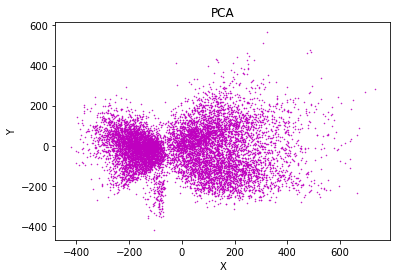

In [ ]:
import matplotlib.pyplot as plt
plt.plot(y_projected[:, 0], y_projected[:, 1], 'ro',color = 'm', markersize = 0.5)
plt.title('PCA')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

取出經過 PCA 後的 encode_vector

In [ ]:
# for cnn
if (model_type == 'cnn'):
    encode_vector = y_reconstructed.reshape(-1, 16, 512, 2, 2) #轉成 cnn_encode
    encode_vector = torch.from_numpy(encode_vector).cuda()  #numpy => tensor，記得放在 gpu

# for fcn  
elif (model_type == 'fcn'):
    encode_vector = y_reconstructed.reshape(-1, 16, 3) #轉成 fcn_encode
    encode_vector = torch.from_numpy(encode_vector).cuda()  #numpy => tensor，記得放在 gpu

# for vae 
else:
    encode_vector = y_reconstructed.reshape(-1, 16, 3) #轉成 vae_encode
    encode_vector = torch.from_numpy(encode_vector).cuda()  #numpy => tensor，記得放在 gpu

In [ ]:
print(len(y_pred))
print(y_pred)

with open('best_model_fcn_0_pca_prediction_1.csv', 'w') as f:
    f.write('id,anomaly\n')
    for i in range(len(y_pred)):
        f.write('{},{}\n'.format(i+1, y_pred[i]))

10000
[3.2027507 2.905815  8.819537  ... 1.0293142 2.0678427 2.7613347]


放回 decoder 預測

In [ ]:
with torch.no_grad():

    reconstructed = list()
    model.eval()
    task = 'ae'
    if task == 'ae':
        if model_type == 'fcn' or model_type == 'vae':
            y = test.reshape(len(test), -1)
        else:
            y = test
       
    for i in range (len(encode_vector)): 
        output = model.decoder(encode_vector[i])
        if model_type == 'cnn':
            output = output.transpose(3, 1)
        elif model_type == 'vae':
            output = output[0]
        reconstructed.append(output.cpu().detach().numpy())

    # np.concatenate 傳入的參數必須是一個多個數組的元組或者列表
    # 另外需要指定拼接的方向，默認是 axis = 0，也就是說對0軸的數組對象進行縱向的拼接（縱向的拼接沿著axis= 1方向）；
    # 注：一般axis = 0，就是對該軸向的數組進行操作，操作方向是另外一個軸，即axis=1。
    reconstructed = np.concatenate(reconstructed, axis=0)
    anomality = np.sqrt(np.sum(np.square(reconstructed - y).reshape(len(y), -1), axis=1))
    y_pred = anomality

    with open('best_model_{}_1_'.format(model_type) + 'knn_decode_prediction_1.csv', 'w') as f:
        f.write('id,anomaly\n')
        for i in range(len(y_pred)):
            f.write('{},{}\n'.format(i+1, y_pred[i]))
    # score = roc_auc_score(y_label, y_pred, average='micro')
    # score = f1_score(y_label, y_pred, average='micro')
    # print('auc score: {}'.format(score))
